In [11]:
import pandas as pd
df = pd.read_csv('tw_train.csv')
df


,交易日,交易別,股票代號,股票名稱,股數,單價,進帳/出帳,Unnamed: 7,XIRR,總成本(賣-買),總價值(現值+配息),總獲利(%),總配息
0,2021/01/11,買,0050,NaN,130.0,131.90,-17147,NaN,23.39%,-448141.0,719607.0,60.576024,28842.0
1,2021/01/15,買,2330,台積,20.0,612.00,-12240,NaN,NaN,NaN,NaN,NaN,NaN
2,2021/01/20,買,2376,技嘉,40.0,79.50,-3180,NaN,NaN,NaN,NaN,NaN,NaN
3,2021/01/25,買,2330,台積,5.0,644.00,-3220,NaN,NaN,NaN,NaN,NaN,NaN
4,2021/01/29,買,2330,NaN,5.0,603.00,-3015,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024/11/29,買,00631L,NaN,10.0,222.75,-2227,NaN,NaN,NaN,NaN,NaN,NaN
140,2025/01/13,買,006208,NaN,30.0,114.70,-3445,NaN,NaN,NaN,NaN,NaN,NaN
141,2025/01/15,買,006208,NaN,20.0,113.25,-2268,NaN,NaN,NaN,NaN,NaN,NaN
142,2025/01/15,買,00631L,NaN,10.0,232.55,-2328,NaN,NaN,NaN,NaN,NaN,NaN


[*********************100%***********************]  8 of 8 completed



=== 總結報告 ===
累積買入金額：661,551.00 元
淨現金流：-420,402.00 元
實際淨投入資金：420,402.00 元
最終組合市值（現有持股）：0.00 元
總獲利：-420,402.00 元
總獲利百分比：-100.00%
XIRR: 20.88%
最終累積績效: -100.00%
每日 IRR: -100.0000%
年化 IRR: -100.00%
夏普值: nan
最大回撤: nan%

=== 投資組合股票明細 ===
+----------+------------+----------------+---------+---------------+--------+----------+------------+
| Symbol   | Name       |   Quantity_now |   Price |   Price_Total |   Cost |     Gain |    Gain(%) |
|----------+------------+----------------+---------+---------------+--------+----------+------------|
| 0050     | 0050       |              0 |  nan    |           nan |  21187 |    349   |   1.64724  |
| 2330     | 台積       |              0 |  nan    |           nan |  39876 |   3004   |   7.53335  |
| 2376     | 技嘉       |            100 |  266.5  |         26650 |   8809 |  17841   | 202.532    |
| 006208   | 006208     |           4566 |  113.95 |        520296 | 364822 | 155474   |  42.6163   |
| 2884     | 玉山金     |              0 |  nan    |         

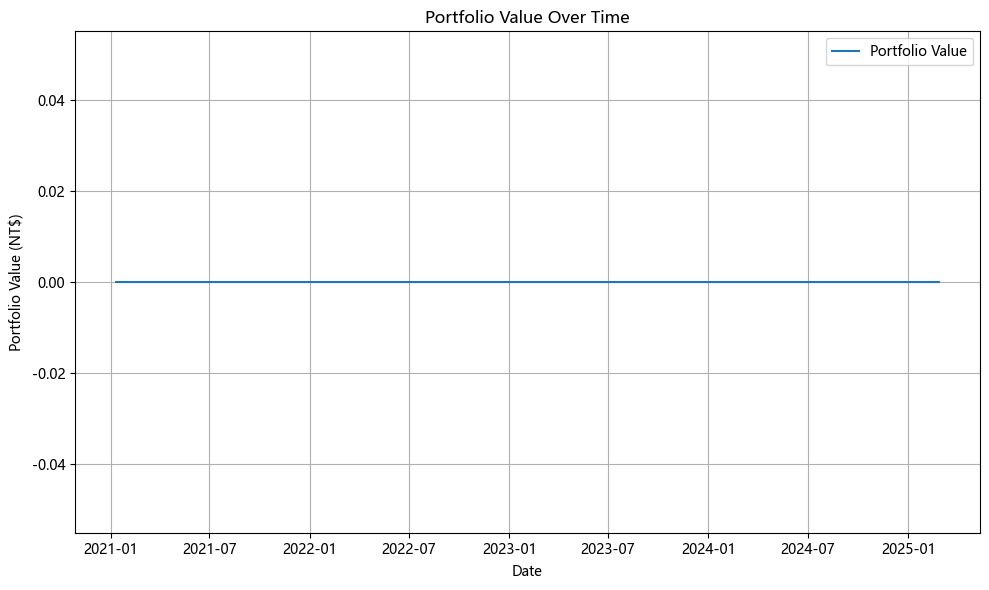

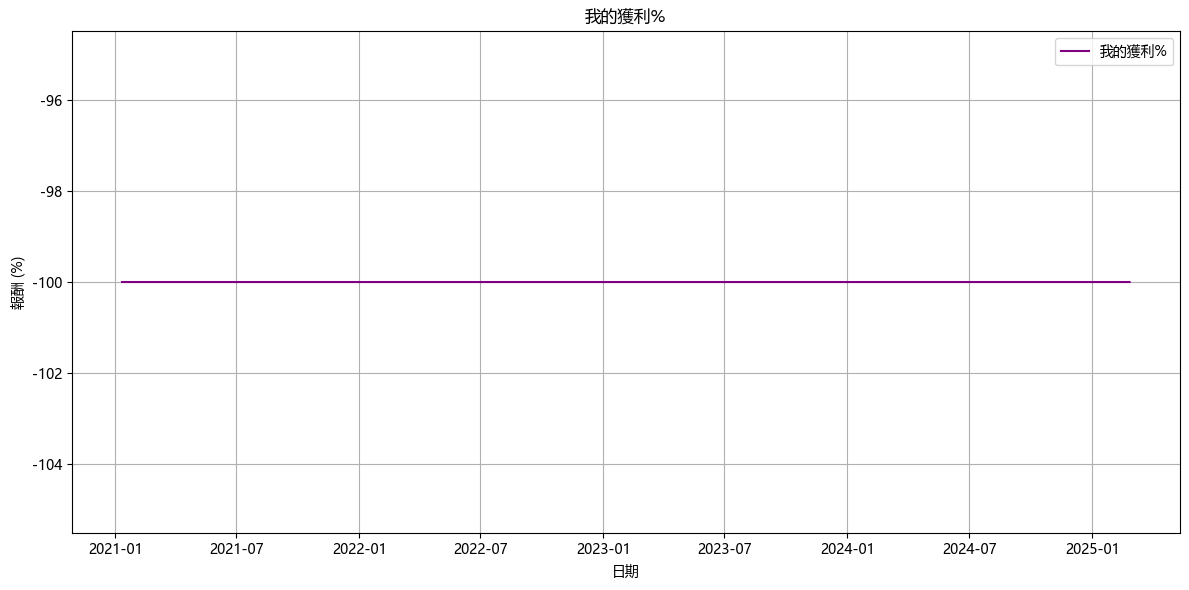

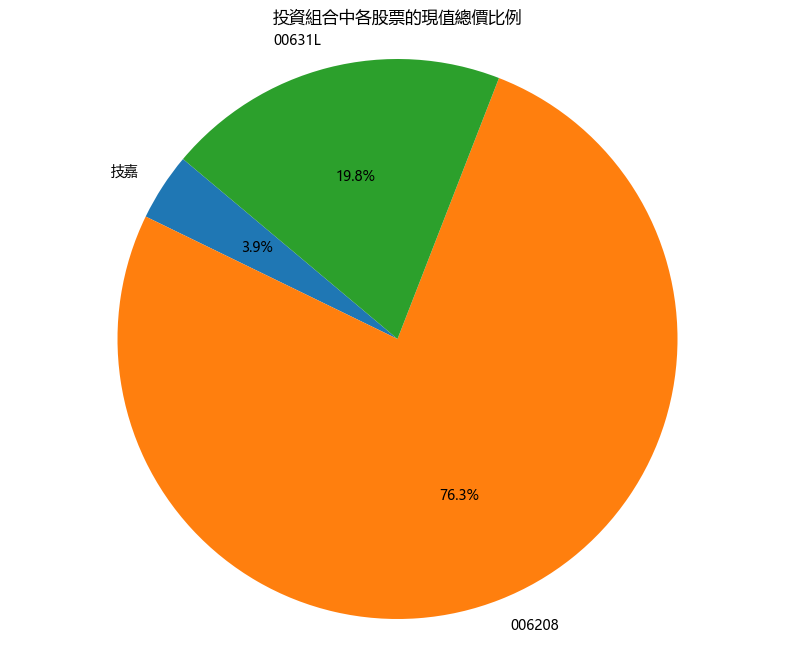

2023/2/10 到 2023/2/15 的市值:
2023-02-10    0.0
2023-02-13    0.0
2023-02-14    0.0
2023-02-15    0.0
Freq: B, dtype: float64

查詢期間每日市值:
2023-02-10    0.0
2023-02-11    0.0
2023-02-12    0.0
2023-02-13    0.0
2023-02-14    0.0
2023-02-15    0.0
Freq: D, dtype: float64


In [47]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import newton
from matplotlib import rcParams
from tabulate import tabulate

# =============================================================================
# 全域設定：設定中文字型與正確顯示負號
# =============================================================================
rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微軟正黑體
rcParams['axes.unicode_minus'] = False

# =============================================================================
# 功能函式
# =============================================================================

def clean_currency(x):
    """
    清理貨幣字串，移除 'NT$', '$' 與逗號，並轉換成 float。
    若轉換失敗則回傳 None。
    """
    if pd.isnull(x) or str(x).strip() == "":
        return None
    try:
        return float(str(x).replace("NT$", "").replace("$", "").replace(",", "").strip())
    except Exception as e:
        print(f"轉換 {x} 失敗: {e}")
        return None

def fix_share_sign(row):
    """
    若交易別為 "賣"（或英文 sell）且 Quantity 為正，則將 Quantity 轉為負值
    """
    action = str(row['Action']).lower()
    if (action == '賣' or action == 'sell') and (row['Quantity'] > 0):
        row['Quantity'] = -row['Quantity']
    return row

def convert_ticker(ticker):
    """
    將台股股票代號轉換成 Yahoo Finance 格式（加上 .TW 後綴）
    """
    if '.' not in ticker:
        return ticker + '.TW'
    return ticker

def get_daily_price(stock_symbol, start_date, end_date):
    """
    利用 yfinance 下載指定股票（或股票列表）每日收盤價資料。
    若為台股，請自動加上 .TW 後綴
    回傳資料中的 'Close' 欄位
    """
    try:
        if isinstance(stock_symbol, list):
            stock_symbol = [convert_ticker(s) for s in stock_symbol]
        else:
            stock_symbol = convert_ticker(stock_symbol)
        data = yf.download(stock_symbol, start=start_date, end=end_date)
        return data['Close']
    except Exception as e:
        print(f"下載 {stock_symbol} 價格失敗: {e}")
        return 0

def get_current_price_yf(ticker):
    """
    利用 yfinance 查詢單一股票的最新價格，
    優先從 info 取得 regularMarketPrice，若無則從 history 中取得最新收盤價
    注意：台股 ticker 需轉換格式
    """
    try:
        ticker = convert_ticker(ticker)
        data = yf.Ticker(ticker)
        price = data.info.get("regularMarketPrice")
        if price is None:
            hist = data.history(period="1d")
            if not hist.empty:
                price = hist["Close"].iloc[-1]
        return price
    except Exception as e:
        print(f"取得 {ticker} 價格失敗: {e}")
        return None

def xnpv(rate, cashflows):
    """
    計算不規則現金流的淨現值 (XNPV)
    :param rate: 折現率
    :param cashflows: [(date, cashflow), ...]
    """
    t0 = min(date for date, _ in cashflows)
    return sum(cf / ((1 + rate) ** ((date - t0).days / 365.0))
               for date, cf in cashflows)

def xirr(cashflows, guess=0.1):
    """
    利用牛頓法求解不規則現金流的內部報酬率 (XIRR)
    :param cashflows: [(date, cashflow), ...]
    :param guess: 初始猜測值
    """
    return newton(lambda r: xnpv(r, cashflows), guess)

def calculate_realized_gain(symbol, df):
    """
    計算已平倉標的的實現盈虧及實現盈虧百分比
    根據原始交易記錄計算：
      - total_buy：買入的總成本（轉為正值）
      - realized_gain：賣出總金額減去買入總成本
      - realized_gain_pct：報酬率
    """
    df_sym = df[df['Symbol'] == symbol]
    total_buy = -df_sym[df_sym['Action'].str.lower().isin(['買', 'buy'])]['Amount'].sum()
    total_sell = df_sym[df_sym['Action'].str.lower().isin(['賣', 'sell'])]['Amount'].sum()
    realized_gain = total_sell - total_buy
    realized_gain_pct = (realized_gain / total_buy * 100) if total_buy != 0 else 0
    return total_buy, realized_gain, realized_gain_pct

# =============================================================================
# 主程式：計算投資組合績效、輸出文字報告，再顯示圖表
# =============================================================================

def main():
    # ------------------------------
    # 1. 讀取並前置處理交易資料
    # ------------------------------
    # 假設 CSV 檔案中有欄位： '交易日', '交易別', '股票代號', '股票名稱', '股數', '單價', '進帳/出帳'
    df = pd.read_csv('tw_train.csv', encoding='utf-8-sig')
    # 重新命名欄位為統一格式
    df.rename(columns={
        '交易日': 'Date',
        '交易別': 'Action',
        '股票代號': 'Symbol',
        '股票名稱': 'Name',
        '股數': 'Quantity',
        '單價': 'Price',
        '進帳/出帳': 'Amount'
    }, inplace=True)
    
    # 轉換日期格式
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    
    # 將賣出時的股數轉為負值
    df = df.apply(fix_share_sign, axis=1)
    
    # 清理金額字串，轉換 Amount 欄位
    df["Amount"] = df["Amount"].apply(clean_currency)

    # 建立日期範圍（從最早交易日到今日，僅包含商業日）
    start_date = df['Date'].min()
    end_date = pd.Timestamp.today()
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # ------------------------------
    # 2. 建立每日累積持股數與組合市值
    # ------------------------------
    pivot = df.pivot_table(index='Date', columns='Symbol', values='Quantity', aggfunc='sum')
    pivot = pivot.reindex(date_range, fill_value=0).fillna(0)
    cum_holdings = pivot.cumsum()
    
    # 取得所有股票代號
    symbols = cum_holdings.columns.tolist()
    
    # 取得各標的每日調整後收盤價資料
    price_data = get_daily_price(symbols, start_date, end_date)
    price_data = price_data.reindex(date_range).ffill().bfill()
    
    # 計算每日投資組合市值
    portfolio_value = (cum_holdings * price_data).sum(axis=1)
    
    # 畫出投資組合市值走勢圖
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_value.index, portfolio_value.values, label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (NT$)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # ※ 此處先不呼叫 plt.show()，以便後續圖表一起顯示

    # ------------------------------
    # 3. 投資績效數值計算與文字輸出（假設所有賣出均再投資）
    # ------------------------------
    
    # (A) 報告用績效指標
    total_investment = -df[df['Amount'] < 0]['Amount'].sum()
    cash_balance = df['Amount'].sum()
    invested_capital = -cash_balance
    final_portfolio_value = portfolio_value.iloc[-1]
    total_profit = final_portfolio_value - invested_capital
    total_profit_pct = (total_profit / invested_capital) * 100
    
    print("\n=== 總結報告 ===")
    print(f"累積買入金額：{total_investment:,.2f} 元")
    print(f"淨現金流：{cash_balance:,.2f} 元")
    print(f"實際淨投入資金：{invested_capital:,.2f} 元")
    print(f"最終組合市值（現有持股）：{final_portfolio_value:,.2f} 元")
    print(f"總獲利：{total_profit:,.2f} 元")
    print(f"總獲利百分比：{total_profit_pct:.2f}%")
    
    # XIRR 計算：現金流包含所有交易與最新組合市值（以今日為日期）
    cashflows = list(df[['Date', 'Amount']].itertuples(index=False, name=None))
    net_holdings = df.groupby('Symbol')['Quantity'].sum()
    portfolio_snapshot = 0
    for stock, shares in net_holdings.items():
        if shares != 0:
            price = get_current_price_yf(stock)
            if price is not None:
                portfolio_snapshot += shares * price
    today = pd.Timestamp.today().normalize()
    cashflows.append((today, portfolio_snapshot))
    
    try:
        irr = xirr(cashflows)
    except Exception as e:
        irr = None
        print("XIRR 計算失敗:", e)
    
    # (B) 時序績效比率計算
    daily_cash_flow = df.groupby('Date')['Amount'].sum().reindex(date_range, fill_value=0).cumsum()
    daily_invested_capital = -daily_cash_flow  # 正值表示累積投入資金
    performance_ratio = pd.Series(np.nan, index=date_range)
    mask = (daily_invested_capital > 0)
    performance_ratio[mask] = portfolio_value[mask] / daily_invested_capital[mask]
    profit_pct_series = (performance_ratio - 1) * 100

    wealth_factor = performance_ratio.dropna()
    if len(wealth_factor) > 0:
        daily_IRR = wealth_factor.iloc[-1] ** (1 / len(wealth_factor)) - 1
        annual_IRR = (1 + daily_IRR) ** 252 - 1
    else:
        daily_IRR = None
        annual_IRR = None

    daily_return = performance_ratio.pct_change()
    annual_rf = 0.02
    daily_rf = annual_rf / 252
    excess_return = daily_return - daily_rf
    sharpe_ratio = np.sqrt(252) * (excess_return.mean() / excess_return.std())
    
    pr_for_dd = profit_pct_series / 100 + 1
    running_max = pr_for_dd.cummax()
    drawdown = pr_for_dd / running_max - 1
    max_drawdown = drawdown.min() * 100

    if irr is not None:
        print(f"XIRR: {irr:.2%}")
    else:
        print("XIRR: 計算失敗")
    
    if daily_IRR is not None and annual_IRR is not None:
        print("最終累積績效: {:.2f}%".format((wealth_factor.iloc[-1] - 1) * 100))
        print(f"每日 IRR: {daily_IRR:.4%}")
        print(f"年化 IRR: {annual_IRR:.2%}")
    else:
        print("IRR: 無法計算")
    
    print(f"夏普值: {sharpe_ratio:.4f}")
    print(f"最大回撤: {max_drawdown:.2f}%")
    
    # ------------------------------
    # 4. 整合個股現值與投資組合股票明細
    # ------------------------------
    stock_counts = {}
    for idx, row in df.iterrows():
        stock_code = row['Symbol']
        stock_name = row['Name'] if pd.notna(row['Name']) else stock_code
        count = row['Quantity']
        cost = float(row['Amount'])
        if pd.isna(stock_code) or pd.isna(count):
            continue
        if stock_code not in stock_counts:
            stock_counts[stock_code] = {'stock_name': stock_name, 'Quantity_now': 0, 'cost': 0}
        stock_counts[stock_code]['Quantity_now'] += count
        stock_counts[stock_code]['cost'] += cost
    
    data_list = []
    for stock_code, data_dict in stock_counts.items():
        name = data_dict['stock_name']
        count = data_dict['Quantity_now']
        aggregated_cost = -data_dict['cost']
        if count != 0:
            try:
                ticker_obj = yf.Ticker(convert_ticker(stock_code))
                current_price = ticker_obj.history(period='1d')['Close'].iloc[-1]
            except Exception as e:
                print(f"Error fetching data for {stock_code}: {e}")
                current_price = 0
            current_value = current_price * count
            gain = current_value - aggregated_cost
            gain_per = (gain / aggregated_cost) * 100 if aggregated_cost != 0 else 0
        else:
            total_buy, realized_gain, realized_gain_pct = calculate_realized_gain(stock_code, df)
            current_price = np.nan
            current_value = np.nan
            aggregated_cost = total_buy
            gain = realized_gain
            gain_per = realized_gain_pct
        data_list.append([stock_code, name, count, current_price, current_value, aggregated_cost, gain, gain_per])
    
    headers = ['Symbol', 'Name', 'Quantity_now', 'Price', 'Price_Total', 'Cost', 'Gain', 'Gain(%)']
    portfolio_df = pd.DataFrame(data_list, columns=headers)
    filtered_df = portfolio_df[portfolio_df['Price_Total'] > 0]
    
    print("\n=== 投資組合股票明細 ===")
    print(tabulate(portfolio_df, headers='keys', tablefmt='psql', showindex=False))
    
    # ------------------------------
    # 5. 建立圖表
    # ------------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(profit_pct_series.index, profit_pct_series.values, label='我的獲利%', color='purple')
    plt.xlabel('日期')
    plt.ylabel('報酬 (%)')
    plt.title('我的獲利%')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 0 else ''
    
    plt.figure(figsize=(10, 8))
    plt.pie(filtered_df['Price_Total'], 
            labels=filtered_df['Name'], 
            autopct=autopct_format, 
            startangle=140)
    plt.title('投資組合中各股票的現值總價比例')
    plt.axis('equal')
    
    plt.show()
    
    # ------------------------------
    # 6. Debug 部分：查詢特定期間市值
    # ------------------------------
    debug_start = pd.Timestamp('2023-02-10')
    debug_end = pd.Timestamp('2023-02-15')
    selected_values = portfolio_value.loc[debug_start:debug_end]
    print("2023/2/10 到 2023/2/15 的市值:")
    print(selected_values)
    
    query_date_range = pd.date_range(debug_start, debug_end, freq='D')
    daily_pf = portfolio_value.reindex(query_date_range, method='ffill')
    print("\n查詢期間每日市值:")
    print(daily_pf)

if __name__ == '__main__':
    main()


[*********************100%***********************]  6 of 6 completed



=== 總結報告 ===
累積買入金額：35,491.21 元
淨現金流：-18,271.35 元
實際淨投入資金：18,271.35 元
最終組合市值（現有持股）：23,321.57 元
總獲利：5,050.22 元
總獲利百分比：27.64%
XIRR: 15.86%
最終累積績效: 27.64%
每日 IRR: 0.0295%
年化 IRR: 7.72%
夏普值: 0.4993
最大回撤: -65.22%

=== 投資組合股票明細 ===
+----------+--------+----------------+---------+---------------+----------+-----------+------------+
| Symbol   | Name   |   Quantity_now |   Price |   Price_Total |     Cost |      Gain |    Gain(%) |
|----------+--------+----------------+---------+---------------+----------+-----------+------------|
| TQQQ     | TQQQ   |              0 | nan     |        nan    |  6175.88 | 3441.68   |  55.7278   |
| EDV      | EDV    |             61 |  71.664 |       4371.5  |  4935.46 | -563.956  | -11.4266   |
| TMF      | TMF    |              0 | nan     |        nan    |    57.79 |  -42.06   | -72.7808   |
| VOO      | VOO    |              0 | nan     |        nan    |  3425.97 |  507.63   |  14.8171   |
| SPLG     | SPLG   |             95 |  70.415 |       6689.43 |  

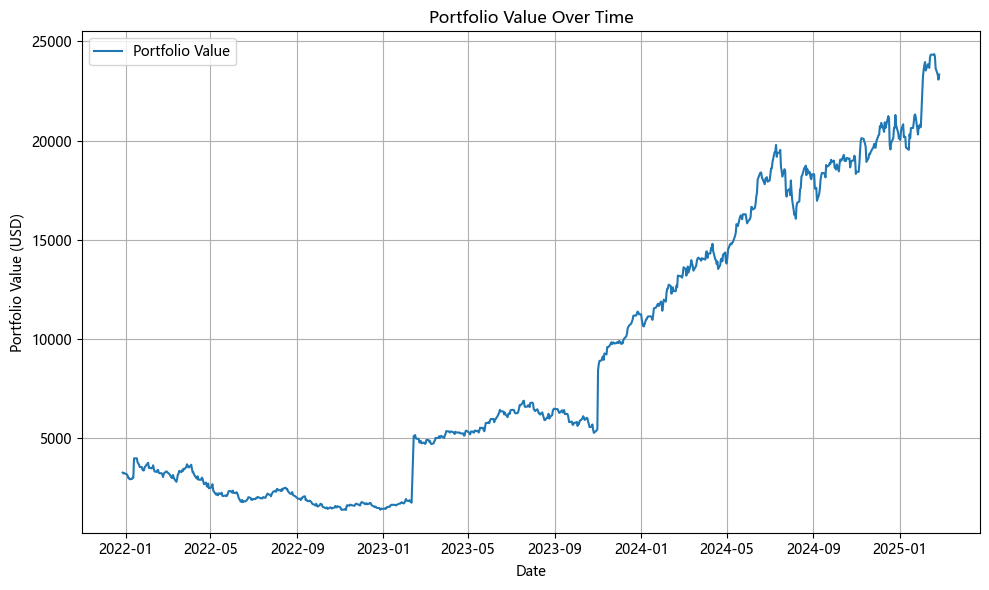

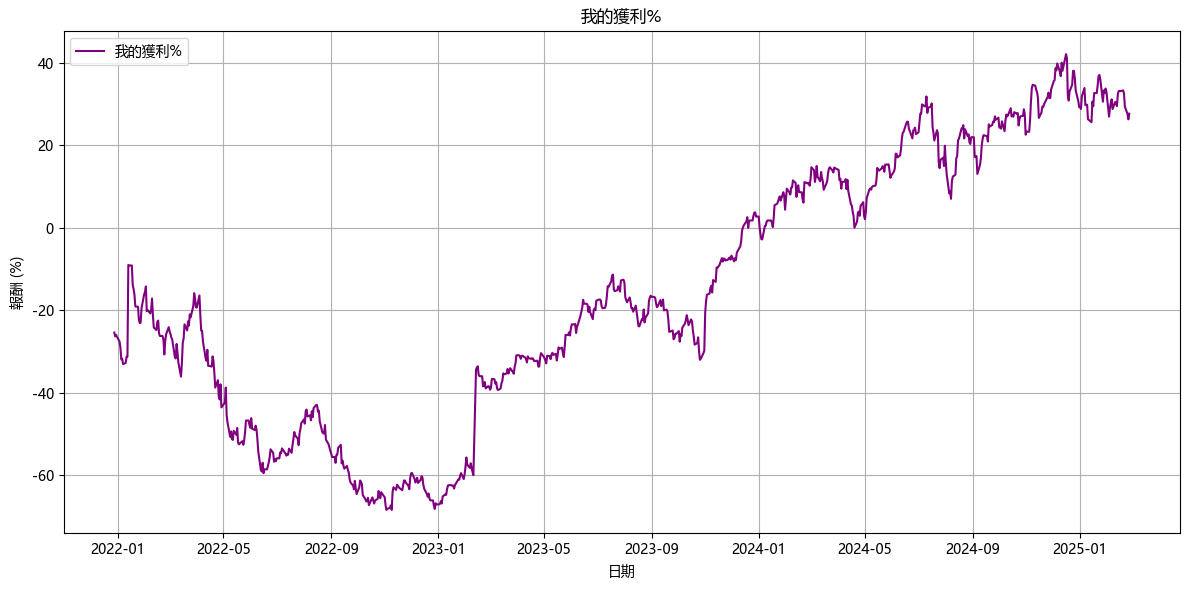

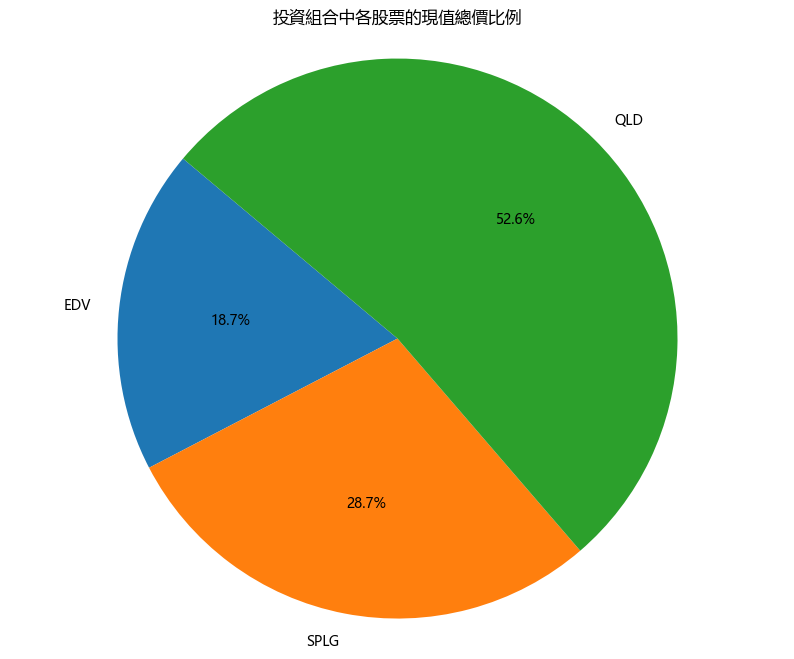

2023/2/10 到 2023/2/15 的市值:
2023-02-10    1744.173840
2023-02-13    5092.296049
2023-02-14    5127.212725
2023-02-15    5152.440659
Freq: B, dtype: float64

查詢期間每日市值:
2023-02-10    1744.173840
2023-02-11    1744.173840
2023-02-12    1744.173840
2023-02-13    5092.296049
2023-02-14    5127.212725
2023-02-15    5152.440659
Freq: D, dtype: float64


In [46]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import newton
from matplotlib import rcParams
from tabulate import tabulate  # 用來美化 DataFrame 輸出

# =============================================================================
# 全域設定：設定中文字型與正確顯示負號
# =============================================================================
rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微軟正黑體
rcParams['axes.unicode_minus'] = False

# =============================================================================
# 功能函式
# =============================================================================

def clean_currency(x):
    """
    清理貨幣字串，移除 '$' 與逗號，並轉換成 float。
    若轉換失敗則回傳 None。
    """
    if pd.isnull(x) or str(x).strip() == "":
        return None
    try:
        return float(str(x).replace("$", "").replace(",", "").strip())
    except Exception as e:
        print(f"轉換 {x} 失敗: {e}")
        return None

def fix_share_sign(row):
    """
    若交易別為 "Sell" 且 Quantity 為正，則將 Quantity 轉為負值
    """
    if (str(row['Action']).lower() == 'sell') and (row['Quantity'] > 0):
        row['Quantity'] = -row['Quantity']
    return row

def get_daily_price(stock_symbol, start_date, end_date):
    """
    利用 yfinance 下載指定股票（或股票列表）每日收盤價資料。
    回傳資料中的 'Close' 欄位
    """
    try:
        data = yf.download(stock_symbol, start=start_date, end=end_date)
        return data['Close']
    except Exception as e:
        print(f"下載 {stock_symbol} 價格失敗: {e}")
        return 0

def get_current_price_yf(ticker):
    """
    利用 yfinance 查詢單一股票的最新價格，
    優先從 info 取得 regularMarketPrice，若無則從 history 中取得最新收盤價
    """
    try:
        data = yf.Ticker(ticker)
        price = data.info.get("regularMarketPrice")
        if price is None:
            hist = data.history(period="1d")
            if not hist.empty:
                price = hist["Close"].iloc[-1]
        return price
    except Exception as e:
        print(f"取得 {ticker} 價格失敗: {e}")
        return None

def xnpv(rate, cashflows):
    """
    計算不規則現金流的淨現值 (XNPV)
    :param rate: 折現率
    :param cashflows: [(date, cashflow), ...]
    """
    t0 = min(date for date, _ in cashflows)
    return sum(cf / ((1 + rate) ** ((date - t0).days / 365.0))
               for date, cf in cashflows)

def xirr(cashflows, guess=0.1):
    """
    利用牛頓法求解不規則現金流的內部報酬率 (XIRR)
    :param cashflows: [(date, cashflow), ...]
    :param guess: 初始猜測值
    """
    return newton(lambda r: xnpv(r, cashflows), guess)

def calculate_realized_gain(symbol, df):
    """
    計算已平倉標的的實現盈虧及實現盈虧百分比
    根據原始交易記錄計算：
      - total_buy：買入的總成本（轉為正值）
      - realized_gain：賣出總金額減去買入總成本
      - realized_gain_pct：報酬率
    """
    df_sym = df[df['Symbol'] == symbol]
    total_buy = -df_sym[df_sym['Action'].str.lower() == 'buy']['Amount'].sum()
    total_sell = df_sym[df_sym['Action'].str.lower() == 'sell']['Amount'].sum()
    realized_gain = total_sell - total_buy
    realized_gain_pct = (realized_gain / total_buy * 100) if total_buy != 0 else 0
    return total_buy, realized_gain, realized_gain_pct

# =============================================================================
# 主程式：計算投資組合績效、輸出文字報告，再顯示圖表
# =============================================================================

def main():
    # ------------------------------
    # 1. 讀取並前置處理交易資料
    # ------------------------------
    # 請確認 CSV 檔案中有欄位： 'Date', 'Action', 'Symbol', 'Quantity', 'Price', 'Amount'
    # 此範例假設檔名為 'us_train.csv'
    df = pd.read_csv('us_train.csv', encoding='utf-8-sig')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df = df.apply(fix_share_sign, axis=1)
    
    # 清理貨幣字串（轉換 Amount 欄位）
    df["Amount"] = df["Amount"].apply(clean_currency)

    # 建立日期範圍（從最早交易日到今日，僅包含商業日）
    start_date = df['Date'].min()
    end_date = pd.Timestamp.today()
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # =============================================================================
    # 2. 建立每日累積持股數與組合市值
    # =============================================================================
    pivot = df.pivot_table(index='Date', columns='Symbol', values='Quantity', aggfunc='sum')
    pivot = pivot.reindex(date_range, fill_value=0).fillna(0)
    cum_holdings = pivot.cumsum()
    
    # 取得所有股票代碼
    symbols = cum_holdings.columns.tolist()
    
    # 取得各標的的每日調整後收盤價資料
    price_data = get_daily_price(symbols, start_date, end_date)
    price_data = price_data.reindex(date_range).ffill().bfill()
    
    # 計算每日投資組合市值
    portfolio_value = (cum_holdings * price_data).sum(axis=1)
    
    # 建立圖表：投資組合市值走勢
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_value.index, portfolio_value.values, label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # ※ 此處不呼叫 plt.show()，先保留圖表

    # ------------------------------
    # 3. 投資績效數值計算與文字輸出（假設所有賣出均再投資）
    # ------------------------------
    
    # (A) 報告用績效指標（單一最終數值）
    # 累積買入金額：買入為負，取負後轉正 (注意：此數值可能大於實際淨投入，因為有重複買入)
    total_investment = -df[df['Amount'] < 0]['Amount'].sum()
    
    # 所有交易的淨現金流：買入為負，賣出為正 (在再投資情況下，通常會是負數)
    cash_balance = df['Amount'].sum()
    # 實際淨投入的資金（正值）
    invested_capital = -cash_balance
    
    # 取得最終持股市值
    final_portfolio_value = portfolio_value.iloc[-1]
    
    # 總獲利：以最終市值減去實際淨投入資金計算
    total_profit = final_portfolio_value - invested_capital
    total_profit_pct = (total_profit / invested_capital) * 100
    
    # 輸出總結報告
    print("\n=== 總結報告 ===")
    print(f"累積買入金額：{total_investment:,.2f} 元")
    print(f"淨現金流：{cash_balance:,.2f} 元")
    print(f"實際淨投入資金：{invested_capital:,.2f} 元")
    print(f"最終組合市值（現有持股）：{final_portfolio_value:,.2f} 元")
    print(f"總獲利：{total_profit:,.2f} 元")
    print(f"總獲利百分比：{total_profit_pct:.2f}%")
    
    # XIRR 計算：現金流包含所有交易與最新組合市值（以今日為日期）
    cashflows = list(df[['Date', 'Amount']].itertuples(index=False, name=None))
    net_holdings = df.groupby('Symbol')['Quantity'].sum()
    portfolio_snapshot = 0
    for stock, shares in net_holdings.items():
        if shares != 0:
            price = get_current_price_yf(stock)
            if price is not None:
                portfolio_snapshot += shares * price
    today = pd.Timestamp.today().normalize()
    cashflows.append((today, portfolio_snapshot))
    
    try:
        irr = xirr(cashflows)
    except Exception as e:
        irr = None
        print("XIRR 計算失敗:", e)
    
    # (B) 時序績效比率計算
    # 以每日累積淨現金流計算（買入為負，故累積後仍為負，取負即為淨投入資金）
    daily_cash_flow = df.groupby('Date')['Amount'].sum().reindex(date_range, fill_value=0).cumsum()
    daily_invested_capital = -daily_cash_flow  # 正值表示累積投入資金
    # 注意：若某天未有任何買入（淨現金流為0），則無法計算績效比率
    performance_ratio = pd.Series(np.nan, index=date_range)
    mask = (daily_invested_capital > 0)
    performance_ratio[mask] = portfolio_value[mask] / daily_invested_capital[mask]
    profit_pct_series = (performance_ratio - 1) * 100

    # 利用最後一日績效比率計算日均與年化報酬率
    wealth_factor = performance_ratio.dropna()
    if len(wealth_factor) > 0:
        daily_IRR = wealth_factor.iloc[-1] ** (1 / len(wealth_factor)) - 1
        annual_IRR = (1 + daily_IRR) ** 252 - 1
    else:
        daily_IRR = None
        annual_IRR = None

    # 夏普值計算：使用每日報酬率扣除無風險利率 (假設年化 2%)
    daily_return = performance_ratio.pct_change()
    annual_rf = 0.02
    daily_rf = annual_rf / 252
    excess_return = daily_return - daily_rf
    sharpe_ratio = np.sqrt(252) * (excess_return.mean() / excess_return.std())
    
    # 計算最大回撤（以 profit_pct_series 為基礎）
    pr_for_dd = profit_pct_series / 100 + 1
    running_max = pr_for_dd.cummax()
    drawdown = pr_for_dd / running_max - 1
    max_drawdown = drawdown.min() * 100

    # 輸出績效指標
    if irr is not None:
        print(f"XIRR: {irr:.2%}")
    else:
        print("XIRR: 計算失敗")
    
    if daily_IRR is not None and annual_IRR is not None:
        print("最終累積績效: {:.2f}%".format((wealth_factor.iloc[-1] - 1) * 100))
        print(f"每日 IRR: {daily_IRR:.4%}")
        print(f"年化 IRR: {annual_IRR:.2%}")
    else:
        print("IRR: 無法計算")
    
    print(f"夏普值: {sharpe_ratio:.4f}")
    print(f"最大回撤: {max_drawdown:.2f}%")
    
    # ------------------------------
    # 4. 整合個股現值與投資組合股票明細
    # ------------------------------
    stock_counts = {}
    for idx, row in df.iterrows():
        stock_code = row['Symbol']
        stock_name = stock_code  # 如有需要，可轉換為全名
        count = row['Quantity']
        cost = float(row['Amount'])
        if pd.isna(stock_code) or pd.isna(count):
            continue
        if stock_code not in stock_counts:
            stock_counts[stock_code] = {'stock_name': stock_name, 'Quantity_now': 0, 'cost': 0}
        stock_counts[stock_code]['Quantity_now'] += count
        stock_counts[stock_code]['cost'] += cost
    
    data_list = []
    for stock_code, data_dict in stock_counts.items():
        name = data_dict['stock_name']
        count = data_dict['Quantity_now']
        # 原始成本：將成本轉為正值（對於尚未平倉部位，此值可能與總買入成本不同）
        aggregated_cost = -data_dict['cost']
        if count != 0:
            # 還有持倉時，使用最新市價計算未實現盈虧
            try:
                ticker = yf.Ticker(stock_code)
                current_price = ticker.history(period='1d')['Close'].iloc[-1]
            except Exception as e:
                print(f"Error fetching data for {stock_code}: {e}")
                current_price = 0
            current_value = current_price * count
            gain = current_value - aggregated_cost
            gain_per = (gain / aggregated_cost) * 100 if aggregated_cost != 0 else 0
        else:
            # 已平倉情況：根據交易記錄計算實現盈虧與報酬率
            total_buy, realized_gain, realized_gain_pct = calculate_realized_gain(stock_code, df)
            current_price = np.nan
            current_value = np.nan
            aggregated_cost = total_buy  # 使用買入總成本作為成本基數
            gain = realized_gain
            gain_per = realized_gain_pct
        data_list.append([stock_code, name, count, current_price, current_value, aggregated_cost, gain, gain_per])
    
    headers = ['Symbol', 'Name', 'Quantity_now', 'Price', 'Price_Total', 'Cost', 'Gain', 'Gain(%)']
    portfolio_df = pd.DataFrame(data_list, columns=headers)
    filtered_df = portfolio_df[portfolio_df['Price_Total'] > 0]
    
    # 輸出投資組合股票明細（使用 tabulate 美化）
    print("\n=== 投資組合股票明細 ===")
    print(tabulate(portfolio_df, headers='keys', tablefmt='psql', showindex=False))
    
    # ------------------------------
    # 5. 建立圖表
    # ------------------------------
    # (1) 我的獲利% 時序圖（使用 profit_pct_series）
    plt.figure(figsize=(12, 6))
    plt.plot(profit_pct_series.index, profit_pct_series.values, label='我的獲利%', color='purple')
    plt.xlabel('日期')
    plt.ylabel('報酬 (%)')
    plt.title('我的獲利%')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # (2) 投資組合中各股票現值比例圓餅圖
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 0 else ''
    
    plt.figure(figsize=(10, 8))
    plt.pie(filtered_df['Price_Total'], 
            labels=filtered_df['Name'], 
            autopct=autopct_format, 
            startangle=140)
    plt.title('投資組合中各股票的現值總價比例')
    plt.axis('equal')
    
    # 顯示所有圖表
    plt.show()
    
    # ------------------------------
    # 6. Debug 部分：查詢特定期間市值
    # ------------------------------
    # 注意：這裡使用新的變數名稱以避免混淆
    debug_start = pd.Timestamp('2023-02-10')
    debug_end = pd.Timestamp('2023-02-15')
    selected_values = portfolio_value.loc[debug_start:debug_end]
    print("2023/2/10 到 2023/2/15 的市值:")
    print(selected_values)
    
    # 建立每日日期範圍 (使用 'D'，包含假日)
    query_date_range = pd.date_range(debug_start, debug_end, freq='D')
    daily_pf = portfolio_value.reindex(query_date_range, method='ffill')
    print("\n查詢期間每日市值:")
    print(daily_pf)

if __name__ == '__main__':
    main()
